# Trabajo 2 - IA

Resumen aqui


In [148]:
!pip install imblearn


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [149]:
import kagglehub

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import scipy.stats as stats
from scipy.stats import shapiro

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

# supervised
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# unsupervised
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, precision_score, accuracy_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# custom transformers

from sklearn.base import BaseEstimator, TransformerMixin

# balanceo

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

from itertools import product
from tqdm.notebook import tqdm

In [150]:
path = kagglehub.dataset_download("therohithanand/used-car-price-prediction", path="used_car_price_dataset_extended.csv")

raw_df = pd.read_csv(path)
raw_df = raw_df.reset_index(drop=True)

### Limpiando el Dataframe

In [151]:
df = raw_df.copy()
df = df.drop(columns=['color', 'service_history', 'brand', 'transmission', 'insurance_valid'])
df.head()

,make_year,mileage_kmpl,engine_cc,fuel_type,owner_count,price_usd,accidents_reported
0,2001,8.17,4000,Petrol,4,8587.64,0
1,2014,17.59,1500,Petrol,4,5943.50,0
2,2023,18.09,2500,Diesel,5,9273.58,1
3,2009,11.28,800,Petrol,1,6836.24,0
4,2005,12.23,1000,Petrol,2,4625.79,0


Se verifica si la variable respuesta es normal o no para elegir el método de balanceo de datos

<Axes: >

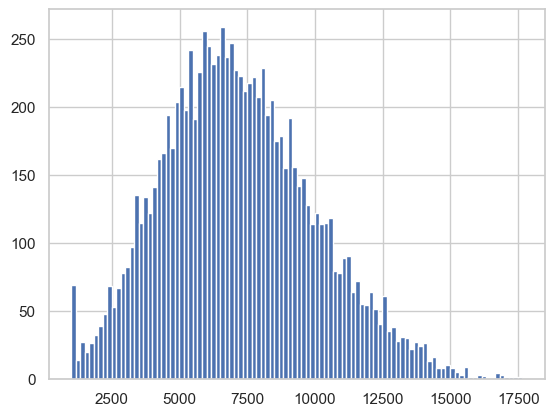

In [152]:
df['price_usd'].hist(bins=100)

In [153]:
# Ejecutar la prueba de Shapiro-Wilk
stat, p_value = shapiro(df['price_usd'])

# Mostrar resultados
print(f'Estadístico W: {stat}')
print(f'Valor p: {p_value}')

# Interpretación
if p_value > 0.05:
    print("Parece una distribución normal (no se rechaza H0)")
else:
    print("No parece una distribución normal (se rechaza H0)")

Estadístico W: 0.9907063127964498
Valor p: 5.045010001757812e-25
No parece una distribución normal (se rechaza H0)


c:\Users\d0ubt\Documents\git\Practica2_introIA\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10000.
  res = hypotest_fun_out(*samples, **kwds)


In [154]:
cols_priority = (df.corr(numeric_only=True).abs()['price_usd'].sort_values(ascending=False)).index[1:]
print(cols_priority.values)

['engine_cc' 'make_year' 'owner_count' 'mileage_kmpl' 'accidents_reported']


In [155]:
df['price_usd'].value_counts(bins=4).sort_index()

(983.351, 5161.908]      2478
(5161.908, 9323.815]     5365
(9323.815, 13485.722]    1960
(13485.722, 17647.63]     197
Name: count, dtype: int64

<Axes: >

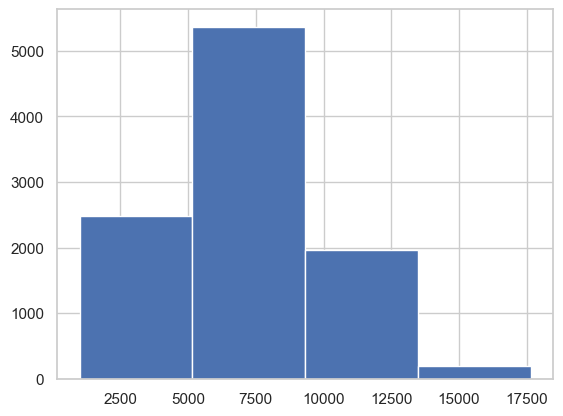

In [156]:
df['price_usd'].hist(bins=4)

In [157]:
#Mapea los categorias
#Convierte todo a categorias en vez de objetos
categorical_cols = df.select_dtypes(include='object').columns

df[categorical_cols] = df[categorical_cols].astype('category')

# convierte la variable objetivo a categorica
labels = ['Very Low', 'Low', 'Moderate', 'High']
df['price_usd'] = pd.cut(df['price_usd'], bins=4, labels=labels, include_lowest=True)

#Insertar variable dependiente de primero por comodidad
price_serie = df['price_usd']
df = df.drop(columns=['price_usd'])
df.insert(0, 'price_usd', price_serie)

df.head()


,price_usd,make_year,mileage_kmpl,engine_cc,fuel_type,owner_count,accidents_reported
0,Low,2001,8.17,4000,Petrol,4,0
1,Low,2014,17.59,1500,Petrol,4,0
2,Low,2023,18.09,2500,Diesel,5,1
3,Low,2009,11.28,800,Petrol,1,0
4,Very Low,2005,12.23,1000,Petrol,2,0


<Axes: xlabel='price_usd', ylabel='count'>

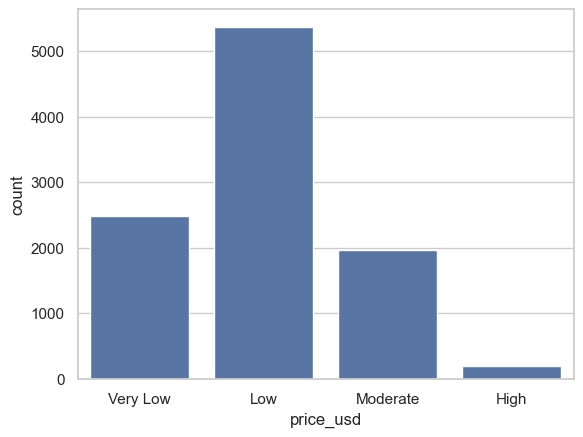

In [158]:
sns.countplot(x='price_usd', data=df, order=labels)

## Preprocesamiento

In [ ]:
class OutliersHandler(BaseEstimator, TransformerMixin):
    """
    Transformer personalizado para el manejo de outliers en conjuntos de datos numéricos.

    Este transformador permite dos modos de operación:
    - Eliminación de outliers usando el criterio del rango intercuartílico (IQR).
    - Generación de outliers sintéticos para asegurar que representen el 5% del total del dataset.

    Parámetros
    ----------
    make_outliers : bool, default=False
        Si es True, se generarán outliers sintéticos en lugar de eliminarlos.
    """
    def __init__(self, make_outliers = False):
        self.column_name = ""
        self.make_outliers = make_outliers

    def fit(self, X, y=None):
        return self  # The fit method typically does nothing for transformers

    def transform(self, X):
        # Your transformation logic goes here
        X_transformed = X.copy()  # Copy the input DataFrame to avoid modifying the original
        X_transformed = self._make_outliers(X_transformed) if self.make_outliers else self._delete_outliers(X_transformed)

        return X_transformed

    # Elimina las filas, donde uno de los valores numericos este fuera de los intervalos
    def _delete_outliers(self, df: pd.DataFrame):
        float_cols = df.select_dtypes('float64').columns

        for col in float_cols:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)

            IQR = Q3 - Q1

            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

        return df

    
    def _make_outliers(self, df: pd.DataFrame, random_state: int = 42) -> pd.DataFrame:
        """
        A partir del df original, detecta sus outliers y genera (replicándolos
        y añadiendo un pequeño ruido) tantas tuplas como hagan falta para que
        los outliers representen el 5% del total.

        Parámetros:
        - df: DataFrame de entrada.
        - random_state: semilla para la aleatoriedad.

        Retorna:
        - DataFrame con 5% outliers o sin outliers.
        """
        df_aux = df.copy()
        float_cols = df_aux.select_dtypes(include='float64').columns

        outlier_mask = pd.Series(False, index=df_aux.index)
        for col in float_cols:
            Q1 = df_aux[col].quantile(0.25)
            Q3 = df_aux[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            outlier_mask |= (df_aux[col] < lower) | (df_aux[col] > upper)

        outliers = df_aux[outlier_mask]
        non_outliers = df_aux[~outlier_mask]

        total_orig = len(df_aux)
        n_outliers = len(outliers)
        target_outliers = int(0.05 * len(df_aux))
        
        # Only generate more if needed
        if n_outliers < target_outliers:
            needed = target_outliers - n_outliers
            synth = outliers.sample(n=needed, replace=True, random_state=random_state)
            
            # Add noise to synthetic outliers
            for col in float_cols:
                noise = np.random.normal(0, 0.1, needed)
                synth[col] = synth[col] * (1 + noise)
            
            # Append synthetic outliers
            df_aux = pd.concat([df_aux, synth], ignore_index=True)
        
        return df_aux


In [160]:
def outliers_maker(data, make_outliers = False):
    outliers = OutliersHandler(make_outliers=make_outliers)
    return outliers.fit_transform(data)

def scaler(X_train, X_test, columns):
    # fit_transform en X_train y transform en X_test
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    std_scaler = StandardScaler()

    X_train_scaled[columns] = std_scaler.fit_transform(X_train[columns])
    X_test_scaled[columns] = std_scaler.transform(X_test[columns])

    return X_train_scaled, X_test_scaled

def X_encoder(X_train : pd.DataFrame, X_test : pd.DataFrame, columns : str):
    # para X_train y X_test (despues de escalar)
    X_train_encoded = X_train.copy()
    X_test_encoded = X_test.copy()
    oh_enc = OneHotEncoder(sparse_output=False)

    # aplicar one_hot
    X_train_cat = oh_enc.fit_transform(X_train[columns])
    X_test_cat = oh_enc.transform(X_test[columns])

    # Get feature names for the encoded columns
    encoded_cat_features = oh_enc.get_feature_names_out(columns)

    # Create DataFrames from encoded arrays
    X_train_cat_df = pd.DataFrame(X_train_cat, index=X_train.index, columns=encoded_cat_features)
    X_test_cat_df = pd.DataFrame(X_test_cat, index=X_test.index, columns=encoded_cat_features)

    # juntar columnas con one_hot con el resto del dataframe
    X_train_encoded = X_train_encoded.drop(columns = columns)
    X_test_encoded = X_test_encoded.drop(columns = columns)
    X_train_encoded = X_train_encoded.join(X_train_cat_df)
    X_test_encoded = X_test_encoded.join(X_test_cat_df)

    return X_train_encoded, X_test_encoded

def y_encoder(y):
    ord_enc = OrdinalEncoder(categories=[['Very Low', 'Low', 'Moderate', 'High']])

    y_encoded = pd.DataFrame(y)

    # aplicar ordinal_enc
    y_encoded = ord_enc.fit_transform(y_encoded)

    # print({i: cat for i, cat in enumerate(list(ord_enc.categories_[0]))})

    return y_encoded

def balancer(X_train, y_train):
    smote = SMOTE(random_state=42)
    return smote.fit_resample(X_train, y_train)


In [161]:
def pipeline_maker(dataframe : pd.DataFrame, model : str, y_label : str = 'price_usd', make_outliers = False, balance = False, scale = False):
    data = dataframe.copy()

    # hacer outliers
    if make_outliers == True:
        data = outliers_maker(data, make_outliers=True)
    else:
        data = outliers_maker(data, make_outliers=False)

    # Encode target variable
    y = y_encoder(data[y_label])
    X = data.drop(columns=[y_label])

    # lista donde se almacenarán los steps a usar
    steps = []

    cat_features = X.select_dtypes(include='category').columns
    num_features = X.select_dtypes(include='number').columns

    # escalado de datos
    if scale:
        col_transformer = ColumnTransformer([
            ('std_scaler', StandardScaler(), num_features),
            ('one_hot', OneHotEncoder(), cat_features)
        ])
    else: # en caso de no escalar
        col_transformer = ColumnTransformer([
            ('one_hot', OneHotEncoder(), cat_features)
        ])
    steps.append(('preprocessor', col_transformer))

    # balanceo con smote
    if balance:
        steps.append(
            ('smote', SMOTE(random_state=42))
            )

    # seleccion de modelo
    if model == 'svm':
        steps.append(
            ('SVC', SVC(random_state=42))
        )
    elif model == 'knn':
        steps.append(
            ('knn', KNeighborsClassifier())
        )
    elif model == 'tree':
        steps.append(
            ('decision_tree', DecisionTreeClassifier(random_state=42))
        )
    elif model == 'nn':
        raise NotImplementedError("modelo no implementado")
        steps.append(
            ('neural_network', None)
        )
    elif model == 'kmeans':
        steps.append(
            ('kmeans', KMeans())
        )
    elif model == 'dbscan':
        steps.append(
            ('dbscan', DBSCAN())
        )
    else:
        raise ValueError("Ingrese uno de los siguientes: 'svm', 'knn', 'tree', 'nn', 'kmeans', 'dbscan'")


    pipeline = imbPipeline(steps)

    return X, y, pipeline

## 2. Aprendizaje Supervisado

### 2.2. Entrenamiento con Árboles, KNN, SVM, y Redes Neuronales.

#### 2.2.1 KNN

In [162]:
# Lista para almacenar información sobre cada configuración de modelo evaluada
knn_info = []

for combo in product([True, False], repeat=3):  # tqdm muestra una barra de progreso
    make_outliers = combo[0]
    balance = combo[1]
    scale = combo[2]

    # Se construye el conjunto de datos y pipeline de preprocesamiento+modelo según las opciones indicadas
    X, y, pipeline = pipeline_maker(df, 'knn',
                                    make_outliers=make_outliers,
                                    balance=balance,
                                    scale=scale)

    # Se divide el dataset en entrenamiento y prueba con estratificación para mantener la proporción de clases
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Definimos los hiperparámetros a explorar con RandomizedSearchCV
    param_dist = {
        'knn__n_neighbors': list(range(2, 30))  # número de vecinos para el clasificador KNN
    }

    # Búsqueda aleatoria de hiperparámetros con validación cruzada 5-fold
    grid = RandomizedSearchCV(
        pipeline,
        param_distributions=param_dist,
        n_iter=10,  # Número de combinaciones aleatorias a evaluar
        cv=5,  # Validación cruzada de 5 folds
        scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'],  # Métricas a evaluar
        refit='f1_macro',  # Se selecciona como mejor modelo el que tenga mejor f1_macro
        verbose=1,
        random_state=42
    )

    # Entrenamos el modelo con los datos de entrenamiento
    grid.fit(X_train, y_train.ravel())

    # Mostramos los mejores parámetros y el mejor score obtenido en validación cruzada
    print("Mejores parámetros encontrados:", grid.best_params_)
    print(f"Mejor score CV: {grid.best_score_:.3f}")

    # Se predice sobre el conjunto de prueba
    y_pred = grid.predict(X_test)

    # Se guarda la información relevante del modelo en un diccionario
    my_model_info = {
        'best_params': grid.best_params_,  # Hiperparámetros óptimos encontrados
        'best_model': grid.best_estimator_,  # Pipeline completo con mejores hiperparámetros
        'metrics': {  # Métricas de desempeño sobre el conjunto de prueba
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, average='macro', zero_division=0),
            'recall': recall_score(y_test, y_pred, average='macro'),
            'f1': f1_score(y_test, y_pred, average='macro')
        },
        'dataset_info': {  # Información sobre la configuración de preprocesamiento
            'make_outliers': make_outliers,
            'balance': balance,
            'scale': scale
        }
    }

    # Agregamos la información del modelo a la lista de resultados
    knn_info.append(my_model_info)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mejores parámetros encontrados: {'knn__n_neighbors': 11}
Mejor score CV: 0.701
Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\d0ubt\Documents\git\Practica2_introIA\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\d0ubt\Documents\git\Practica2_introIA\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\d0ubt\Documents\git\Practica2_introIA\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

Mejores parámetros encontrados: {'knn__n_neighbors': 2}
Mejor score CV: 0.264
Fitting 5 folds for each of 10 candidates, totalling 50 fits


Exception ignored in: <function tqdm.__del__ at 0x000001ABB6535940>
Traceback (most recent call last):
  File "c:\Users\d0ubt\Documents\git\Practica2_introIA\.venv\Lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "c:\Users\d0ubt\Documents\git\Practica2_introIA\.venv\Lib\site-packages\tqdm\notebook.py", line 282, in close
    self.disp(bar_style='success', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Exception ignored in: <function tqdm.__del__ at 0x000001ABB6535940>
Traceback (most recent call last):
  File "c:\Users\d0ubt\Documents\git\Practica2_introIA\.venv\Lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "c:\Users\d0ubt\Documents\git\Practica2_introIA\.venv\Lib\site-packages\tqdm\notebook.py", line 282, in close
    self.disp(bar_style='success', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Exception ignored in: <function tqdm.__del__ at 0x000001ABB653

KeyboardInterrupt: 

In [ ]:
knn_info

[{'best_params': {'knn__n_neighbors': 14},
  'best_model': Pipeline(steps=[('preprocessor',
                   ColumnTransformer(transformers=[('std_scaler',
                                                    StandardScaler(),
                                                    Index(['make_year', 'mileage_kmpl', 'engine_cc', 'owner_count',
         'accidents_reported'],
        dtype='object')),
                                                   ('one_hot', OneHotEncoder(),
                                                    Index(['fuel_type', 'brand', 'transmission', 'insurance_valid'], dtype='object'))])),
                  ('smote', SMOTE(random_state=42)),
                  ('knn', KNeighborsClassifier(n_neighbors=14))]),
  'metrics': {'accuracy': 0.7104634495938844,
   'precision': 0.6264016360618314,
   'recall': 0.7477271952259164,
   'f1': 0.6592213859355807},
  'dataset_info': {'make_outliers': True, 'balance': True, 'scale': True}},
 {'best_params': {'knn__n_neighbors': 2

#### 2.2.2. SVM

In [ ]:
# Lista para almacenar información sobre cada configuración de modelo evaluada
svm_info = []

for combo in tqdm(product([True, False], repeat=3)):  # tqdm muestra una barra de progreso
    make_outliers = combo[0]
    balance = combo[1]
    scale = combo[2]

    # Se construye el conjunto de datos y pipeline de preprocesamiento+modelo según las opciones indicadas
    X, y, pipeline = pipeline_maker(df, 'svm',
                                    make_outliers=make_outliers,
                                    balance=balance,
                                    scale=scale)

    # Se divide el dataset en entrenamiento y prueba con estratificación para mantener la proporción de clases
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Definimos los hiperparámetros a explorar con RandomizedSearchCV
    param_dist = {
        'SVC__C': np.logspace(-3, 0, num = 10),
        'SVC__kernel': ['linear', 'rbf', 'poly'],
        'SVC__gamma': np.logspace(-2, 0, num = 10)
    }

    # Búsqueda aleatoria de hiperparámetros con validación cruzada 5-fold
    grid = RandomizedSearchCV(
        pipeline,
        param_distributions=param_dist,
        n_iter=10,  # Número de combinaciones aleatorias a evaluar
        cv=5,  # Validación cruzada de 5 folds
        scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'],  # Métricas a evaluar
        refit='f1_macro',  # Se selecciona como mejor modelo el que tenga mejor f1_macro
        verbose=2,
        random_state=42
    )

    # Entrenamos el modelo con los datos de entrenamiento
    grid.fit(X_train, y_train.ravel())

    # Mostramos los mejores parámetros y el mejor score obtenido en validación cruzada
    print("Mejores parámetros encontrados:", grid.best_params_)
    print(f"Mejor score CV: {grid.best_score_:.3f}")

    # Se predice sobre el conjunto de prueba
    y_pred = grid.predict(X_test)

    # Se guarda la información relevante del modelo en un diccionario
    my_model_info = {
        'best_params': grid.best_params_,  # Hiperparámetros óptimos encontrados
        'best_model': grid.best_estimator_,  # Pipeline completo con mejores hiperparámetros
        'metrics': {  # Métricas de desempeño sobre el conjunto de prueba
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, average='macro', zero_division=0),
            'recall': recall_score(y_test, y_pred, average='macro'),
            'f1': f1_score(y_test, y_pred, average='macro')
        },
        'dataset_info': {  # Información sobre la configuración de preprocesamiento
            'make_outliers': make_outliers,
            'balance': balance,
            'scale': scale
        }
    }

    # Agregamos la información del modelo a la lista de resultados
    svm_info.append(my_model_info)


0it [00:00, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END SVC__C=0.1, SVC__gamma=0.3593813663804626, SVC__kernel=poly; total time=   3.8s
[CV] END SVC__C=0.1, SVC__gamma=0.3593813663804626, SVC__kernel=poly; total time=   2.6s
[CV] END SVC__C=0.1, SVC__gamma=0.3593813663804626, SVC__kernel=poly; total time=   2.9s
[CV] END SVC__C=0.1, SVC__gamma=0.3593813663804626, SVC__kernel=poly; total time=   3.4s
[CV] END SVC__C=0.1, SVC__gamma=0.3593813663804626, SVC__kernel=poly; total time=   2.6s
[CV] END SVC__C=0.46415888336127775, SVC__gamma=0.5994842503189409, SVC__kernel=poly; total time=   9.3s
[CV] END SVC__C=0.46415888336127775, SVC__gamma=0.5994842503189409, SVC__kernel=poly; total time=   9.0s
[CV] END SVC__C=0.46415888336127775, SVC__gamma=0.5994842503189409, SVC__kernel=poly; total time=   9.6s
[CV] END SVC__C=0.46415888336127775, SVC__gamma=0.5994842503189409, SVC__kernel=poly; total time=   8.8s
[CV] END SVC__C=0.46415888336127775, SVC__gamma=0.5994842503189409, SVC__k

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END SVC__C=0.046415888336127774, SVC__gamma=0.01, SVC__kernel=poly; total time=  17.4s
[CV] END SVC__C=0.046415888336127774, SVC__gamma=0.01, SVC__kernel=poly; total time=  17.0s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END SVC__C=0.046415888336127774, SVC__gamma=0.01, SVC__kernel=poly; total time=  17.6s
[CV] END SVC__C=0.046415888336127774, SVC__gamma=0.01, SVC__kernel=poly; total time=  19.7s
[CV] END SVC__C=0.046415888336127774, SVC__gamma=0.01, SVC__kernel=poly; total time=  17.7s
[CV] END SVC__C=0.001, SVC__gamma=0.046415888336127774, SVC__kernel=linear; total time=   6.2s
[CV] END SVC__C=0.001, SVC__gamma=0.046415888336127774, SVC__kernel=linear; total time=   7.2s
[CV] END SVC__C=0.001, SVC__gamma=0.046415888336127774, SVC__kernel=linear; total time=   6.2s
[CV] END SVC__C=0.001, SVC__gamma=0.046415888336127774, SVC__kernel=linear; total time=   7.1s
[CV] END SVC__C=0.001, SVC__gamma=0.046415888336127774, SVC__kernel=linear; total time=   6.2s
[CV] END SVC__C=0.21544346900318823, SVC__gamma=0.3593813663804626, SVC__kernel=poly; total time=   3.7s
[CV] END SVC__C=0.21544346900318823, SVC__gamma=0.3593813663804626, SVC__kernel=poly; total time=   3.0s
[CV] END SVC__C=0.21544346900318823, SV

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END SVC__C=0.001, SVC__gamma=0.016681005372000592, SVC__kernel=poly; total time=  17.6s
[CV] END SVC__C=0.001, SVC__gamma=0.016681005372000592, SVC__kernel=poly; total time=  17.0s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END SVC__C=0.001, SVC__gamma=0.016681005372000592, SVC__kernel=poly; total time=  17.0s
[CV] END SVC__C=0.001, SVC__gamma=0.016681005372000592, SVC__kernel=poly; total time=  17.8s
[CV] END SVC__C=0.001, SVC__gamma=0.016681005372000592, SVC__kernel=poly; total time=  16.9s
[CV] END SVC__C=0.046415888336127774, SVC__gamma=0.5994842503189409, SVC__kernel=rbf; total time=  19.1s
[CV] END SVC__C=0.046415888336127774, SVC__gamma=0.5994842503189409, SVC__kernel=rbf; total time=  21.0s
[CV] END SVC__C=0.046415888336127774, SVC__gamma=0.5994842503189409, SVC__kernel=rbf; total time=  15.1s
[CV] END SVC__C=0.046415888336127774, SVC__gamma=0.5994842503189409, SVC__kernel=rbf; total time=  17.5s
[CV] END SVC__C=0.046415888336127774, SVC__gamma=0.5994842503189409, SVC__kernel=rbf; total time=  13.8s
Mejores parámetros encontrados: {'SVC__kernel': 'rbf', 'SVC__gamma': np.float64(0.1291549665014884), 'SVC__C': np.float64(0.21544346900318823)}
Mejor score CV: 0.743
Fitting 5 folds for each of 10

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END SVC__C=0.001, SVC__gamma=0.046415888336127774, SVC__kernel=linear; total time=  17.9s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END SVC__C=0.001, SVC__gamma=0.046415888336127774, SVC__kernel=linear; total time=  18.4s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END SVC__C=0.001, SVC__gamma=0.046415888336127774, SVC__kernel=linear; total time=  17.7s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END SVC__C=0.001, SVC__gamma=0.046415888336127774, SVC__kernel=linear; total time=  17.6s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END SVC__C=0.001, SVC__gamma=0.046415888336127774, SVC__kernel=linear; total time=  17.8s
[CV] END SVC__C=0.21544346900318823, SVC__gamma=0.3593813663804626, SVC__kernel=poly; total time=  13.8s
[CV] END SVC__C=0.21544346900318823, SVC__gamma=0.3593813663804626, SVC__kernel=poly; total time=  14.2s
[CV] END SVC__C=0.21544346900318823, SVC__gamma=0.3593813663804626, SVC__kernel=poly; total time=  14.0s
[CV] END SVC__C=0.21544346900318823, SVC__gamma=0.3593813663804626, SVC__kernel=poly; total time=  13.7s
[CV] END SVC__C=0.21544346900318823, SVC__gamma=0.3593813663804626, SVC__kernel=poly; total time=  13.7s
[CV] END SVC__C=0.21544346900318823, SVC__gamma=0.1291549665014884, SVC__kernel=rbf; total time=  17.6s
[CV] END SVC__C=0.21544346900318823, SVC__gamma=0.1291549665014884, SVC__kernel=rbf; total time=  18.4s
[CV] END SVC__C=0.21544346900318823, SVC__gamma=0.1291549665014884, SVC__kernel=rbf; total time=  17.4s
[CV] END SVC__C=0.21544346900318823, SVC__gamma=0.1291549665014884, 

In [ ]:
[model['metrics'] for model in svm_info]

# MODELOS NO SUPERVISADOS

## KMEANS

In [163]:
results = {}

# Recorremos todas las combinaciones de True y False
for make_outliers in [True, False]:
    for balance in [True, False]:
        for scale in [True, False]:
            
            X, y, _ = pipeline_maker(df, 'kmeans', make_outliers=make_outliers, balance=balance, scale=scale)
            X = pd.get_dummies(X)

            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, stratify=y, random_state=42)

            # Scaling manual si se requiere
            if scale:
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)
                X_test = scaler.transform(X_test)

            # Inicializar listas
            inertia_list = []
            silhouette_list = []

            # Probar KMeans para k de 1 a 20
            for k in range(2, 21):
                kmeans = KMeans(n_clusters=k, random_state=42)
                labels = kmeans.fit_predict(X_train)
                inertia_list.append(kmeans.inertia_)

                if k >= 2:
                    silhouette = silhouette_score(X_train, labels)
                else:
                    silhouette = None  # No se define para k=1
                silhouette_list.append(silhouette)

            # Guardar resultados
            key = f"outliers_{make_outliers}_balance_{balance}_scale_{scale}"
            results[key] = {
                "inertia": inertia_list,
                "silhouette": silhouette_list
            }

            

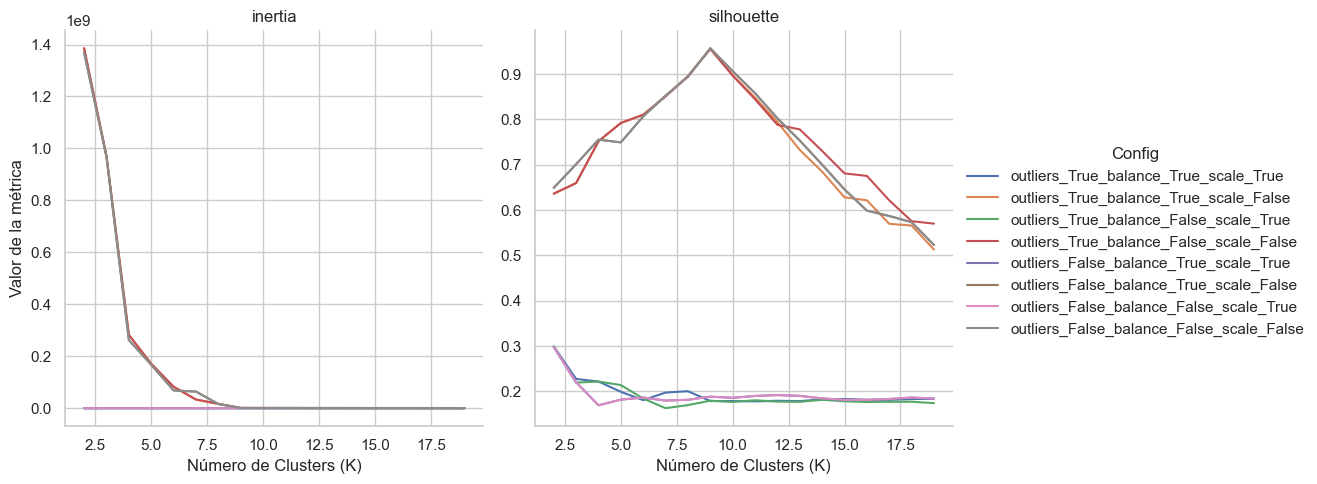

In [164]:
# Tu diccionario (asegúrate de definirlo antes, lo puedes cargar como 'data')
data = results
# Preparar los datos en un DataFrame largo
rows = []
for config, metrics in data.items():
    for metric_name, values in metrics.items():
        for i, value in enumerate(values[1:], start=2):  # desde índice 2 hasta len(lista)
            rows.append({
                'Config': config,
                'Metric': metric_name,
                'Value': float(value),
                'K': i
            })

df = pd.DataFrame(rows)

# Crear la gráfica con seaborn: dos gráficas separadas por métrica
sns.set(style="whitegrid")
g = sns.relplot(
    data=df, 
    x='K', y='Value',
    hue='Config',
    col='Metric',
    kind='line',
    facet_kws={'sharey': False, 'sharex': True}
)

g.set_titles(col_template="{col_name}")
g.set_axis_labels("Número de Clusters (K)", "Valor de la métrica")
plt.show()

In [165]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 1️⃣  Encuentra la mejor configuración usando la métrica de silhouette promedio
best_score = -1
best_config = None
best_k = None

for key, value in results.items():
    silhouettes = value["silhouette"]
    # Silhouette puede tener valores None, filtramos
    valid_silhouettes = [s for s in silhouettes if s is not None]
    max_silhouette = max(valid_silhouettes)
    k = valid_silhouettes.index(max_silhouette) + 2  # +2 porque empiezas en k=2
    if max_silhouette > best_score:
        best_score = max_silhouette
        best_config = key
        best_k = k

print(f"Mejor configuración: {best_config} con k={best_k} y silhouette={best_score:.3f}")

# 2️⃣  Reconstruye los datos con esa configuración
# Parseamos configuración
best_outliers = "outliers_True" in best_config
best_balance = "balance_True" in best_config
best_scale = "scale_True" in best_config

X, y, _ = pipeline_maker(df, 'kmeans',
                         make_outliers=best_outliers,
                         balance=best_balance,
                         scale=best_scale)
X = pd.get_dummies(X)

# 3️⃣  Divide y escala si corresponde
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

if best_scale:
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

# 4️⃣  Ajusta KMeans con el mejor k
kmeans = KMeans(n_clusters=best_k, random_state=42)
labels = kmeans.fit_predict(X_train)

# 5️⃣  Reduce a 2D con PCA o TSNE
# PCA es rápido; TSNE es más detallado pero lento
# Aquí uso PCA:
pca = PCA(n_components=2)
X_2D = pca.fit_transform(X_train)

# 6️⃣  Grafica
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_2D[:, 0], X_2D[:, 1], c=labels, cmap='tab10', alpha=0.7)
plt.title(f'Clusters del mejor modelo\n{best_config} con k={best_k}')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(scatter, label='Cluster')
plt.show()

Mejor configuración: outliers_False_balance_True_scale_False con k=10 y silhouette=0.957


KeyError: 'price_usd'

## DBSCAN

In [166]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

results = {}

for make_outliers in [True, False]:
    for balance in [True, False]:
        for scale in [True, False]:
            
            # Preprocesamiento de datos
            X, y, _ = pipeline_maker(df, 'kmeans', make_outliers=make_outliers, balance=balance, scale=scale)
            X = pd.get_dummies(X)
            
            # División train-test (usamos solo X_train para clustering)
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, stratify=y, random_state=42)
            
            # Escalado manual si es necesario
            if scale:
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)
                X_test = scaler.transform(X_test)
            
            # Definir rangos de parámetros para DBSCAN
            eps_values = [0.1, 0.5, 1.0, 1.5, 2.0] if scale else [1, 5, 10, 50, 100]
            min_samples_values = [5, 10, 15]
            
            best_silhouette = -1  # Valor inicial (Silhouette Score varía en [-1, 1])
            best_eps = None
            best_min_samples = None
            best_n_clusters = None
            
            # Probar combinaciones de parámetros para DBSCAN
            for eps in eps_values:
                for min_samples in min_samples_values:
                    db = DBSCAN(eps=eps, min_samples=min_samples)
                    labels = db.fit_predict(X_train)
                    
                    # Identificar clusters válidos (excluyendo ruido: etiqueta -1)
                    unique_labels = set(labels)
                    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
                    
                    # Requerimos al menos 2 clusters para calcular Silhouette
                    if n_clusters < 2:
                        continue
                    
                    # Filtrar puntos no ruidosos
                    mask = labels != -1
                    labels_non_noise = labels[mask]
                    
                    # Verificar clusters válidos en puntos no ruidosos
                    if len(set(labels_non_noise)) < 2:
                        continue
                    
                    # Calcular Silhouette Score solo en puntos no ruidosos
                    try:
                        silhouette = silhouette_score(X_train[mask], labels_non_noise)
                    except:
                        continue
                    
                    # Actualizar mejor combinación si se mejora el score
                    if silhouette > best_silhouette:
                        best_silhouette = silhouette
                        best_eps = eps
                        best_min_samples = min_samples
                        best_n_clusters = n_clusters
            
            # Guardar resultados
            key = f"outliers_{make_outliers}_balance_{balance}_scale_{scale}"
            results[key] = {
                "best_eps": best_eps,
                "best_min_samples": best_min_samples,
                "n_clusters": best_n_clusters,
                "silhouette_score": best_silhouette
            }

# Mostrar resultados
for config, params in results.items():
    print(f"\nConfiguración: {config}")
    print(f"Mejor eps: {params['best_eps']}")
    print(f"Mejor min_samples: {params['best_min_samples']}")
    print(f"Número de clusters: {params['n_clusters']}")
    print(f"Silhouette Score: {params['silhouette_score']:.3f}")

KeyError: 'price_usd'